<a href="https://colab.research.google.com/github/p-disha/Continual-Learning-AI/blob/master/Continual_Learning_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Continual Learning and Catastrophic Interference**

Advancements in continual learning (aka lifelong learning) have the potential to improve the efficacy and generalizability of predicitive models that adapt to changing conditions. This is even more important in environemnts with a real-time or fast collect input-predict-observe feedback loop such as robotics.

A good continual learning model has a few notable properties. It is generalizable,  meaning that knowledge gained from one task can be applied to help perform other tasks. While being generalizable, the model still retains enough task-specific knowledge to perform disparate tasks well. 
Good models acheive a balance of flexibility where new tasks are effectively learned and stability where learning new tasks does not interfere with previous knowledge. 

Catastrophic interference is one of key challeges in continual learning. Catastrophic interference occurs when learning new tasks leads to a failure to accurately perform previously learned tasks. Naive continual learning models allow this to happen when new learning overwrites or modifies the weights associated with previously learned tasks. 

**There are different approaches to overcoming catastrophic learning:**
- Storing all previous data and retrain models after aquiring new data or performing new tasks. 
  - This approach is resource intensive (CPU-cycles, memory, time) and is not appropriate in many applications
- Performing network expansions where additional neural resources are allocated to model the new tasks without changing the underlying knowledge
  - This approach does not scale well with an increasing number of tasks and can also become resouce intensive
- Non-overlapping task representations can be constructed
  - This approach does not suffer from catastrophic interference becuase each task effectively has a distinct model. However, there is no generalizability 
- Old and new knowledge can be interleaved to prevent new information from exessively modifying old knowledge
  - This requires more memory and mechanisms to protect older knowledge
- Regularization terms on loss functions to limit how much new information can modify model weights
  - Regularization reduces but does not prevent catastrophic interference as model weights are still updated by new information. Additionally, the magnitude of weight changes from new information is skewed towards earlier examples
- Complementary learning systems that use both short-term and long-term weights to combine general, longer-term knowledge with task-specific, shorter-term knowledge

**Gradient Episodic Memory (GEM)**

Gradient Episodic Memory is a type of complementary learning system that uses per-task or per-episode memory to both perform effectively on current task while reducing the potential for catstrophic interference or even improving previous tasks(positive backwards transfer). This is facilitated through minimizing the current task's loss function subject to the loss not significantly increasing for previous episode-specific functions. GEM requires more memory than other approaches (such as regularization) but peforms better in single-pass settings and with frequent, small batches of data. 


**Our Approach**

We decided to compare GEM to four of the models (single,independent,multimodal,EWC) in Lopez-Ranzato paper(http://papers.nips.cc/paper/7225-gradient-episodic-memory-for-continual-learning.pdf) using the MNIST and MNIST permuted data sets. 




In [ ]:
import numpy as np
import subprocess
import pickle
import torch
import os
import math
import torch.nn as nn
from torch.nn.functional import relu, avg_pool2d
import torch.optim as optim
import numpy as np
import argparse

**Data Sets** 

The MNIST image set consists of 70,000 hand-written digits. 60,000 are used for training and 10,000 for testing. The permuted dataset contains modified MNIST images to represent new tasks or classes. 



In [ ]:

cifar_path = "cifar-100-python.tar.gz"
mnist_path = "mnist.npz"

# URL from: https://www.cs.toronto.edu/~kriz/cifar.html
if not os.path.exists(cifar_path):
    subprocess.call("wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", shell=True)

subprocess.call("tar xzfv cifar-100-python.tar.gz", shell=True)

# URL from: https://github.com/fchollet/keras/blob/master/keras/datasets/mnist.py
if not os.path.exists(mnist_path):
    subprocess.call("wget https://s3.amazonaws.com/img-datasets/mnist.npz", shell=True)



In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



Here we load the data we will work with, create Pytorch Tensor objects from ndarrays, and save the Tensor objects to disk. Tensors can be though of somewhat like multidimensional matrices.  

In [ ]:
cifar100_train = unpickle('cifar-100-python/train')
cifar100_test = unpickle('cifar-100-python/test')

x_tr = torch.from_numpy(cifar100_train[b'data'])
y_tr = torch.LongTensor(cifar100_train[b'fine_labels'])
x_te = torch.from_numpy(cifar100_test[b'data'])
y_te = torch.LongTensor(cifar100_test[b'fine_labels'])

torch.save((x_tr, y_tr, x_te, y_te), 'cifar100.pt')

f = np.load('mnist.npz')
x_mnist_tr = torch.from_numpy(f['x_train'])
y_mnist_tr = torch.from_numpy(f['y_train']).long()
x_mnist_te = torch.from_numpy(f['x_test'])
y_mnist_te = torch.from_numpy(f['y_test']).long()
f.close()

torch.save((x_mnist_tr, y_mnist_tr), 'mnist_train.pt')
torch.save((x_mnist_te, y_mnist_te), 'mnist_test.pt')

Using matplotlib, we take a look at a sample of the MNIST data

[0 1 2 3 4 5 6 7 8 9]


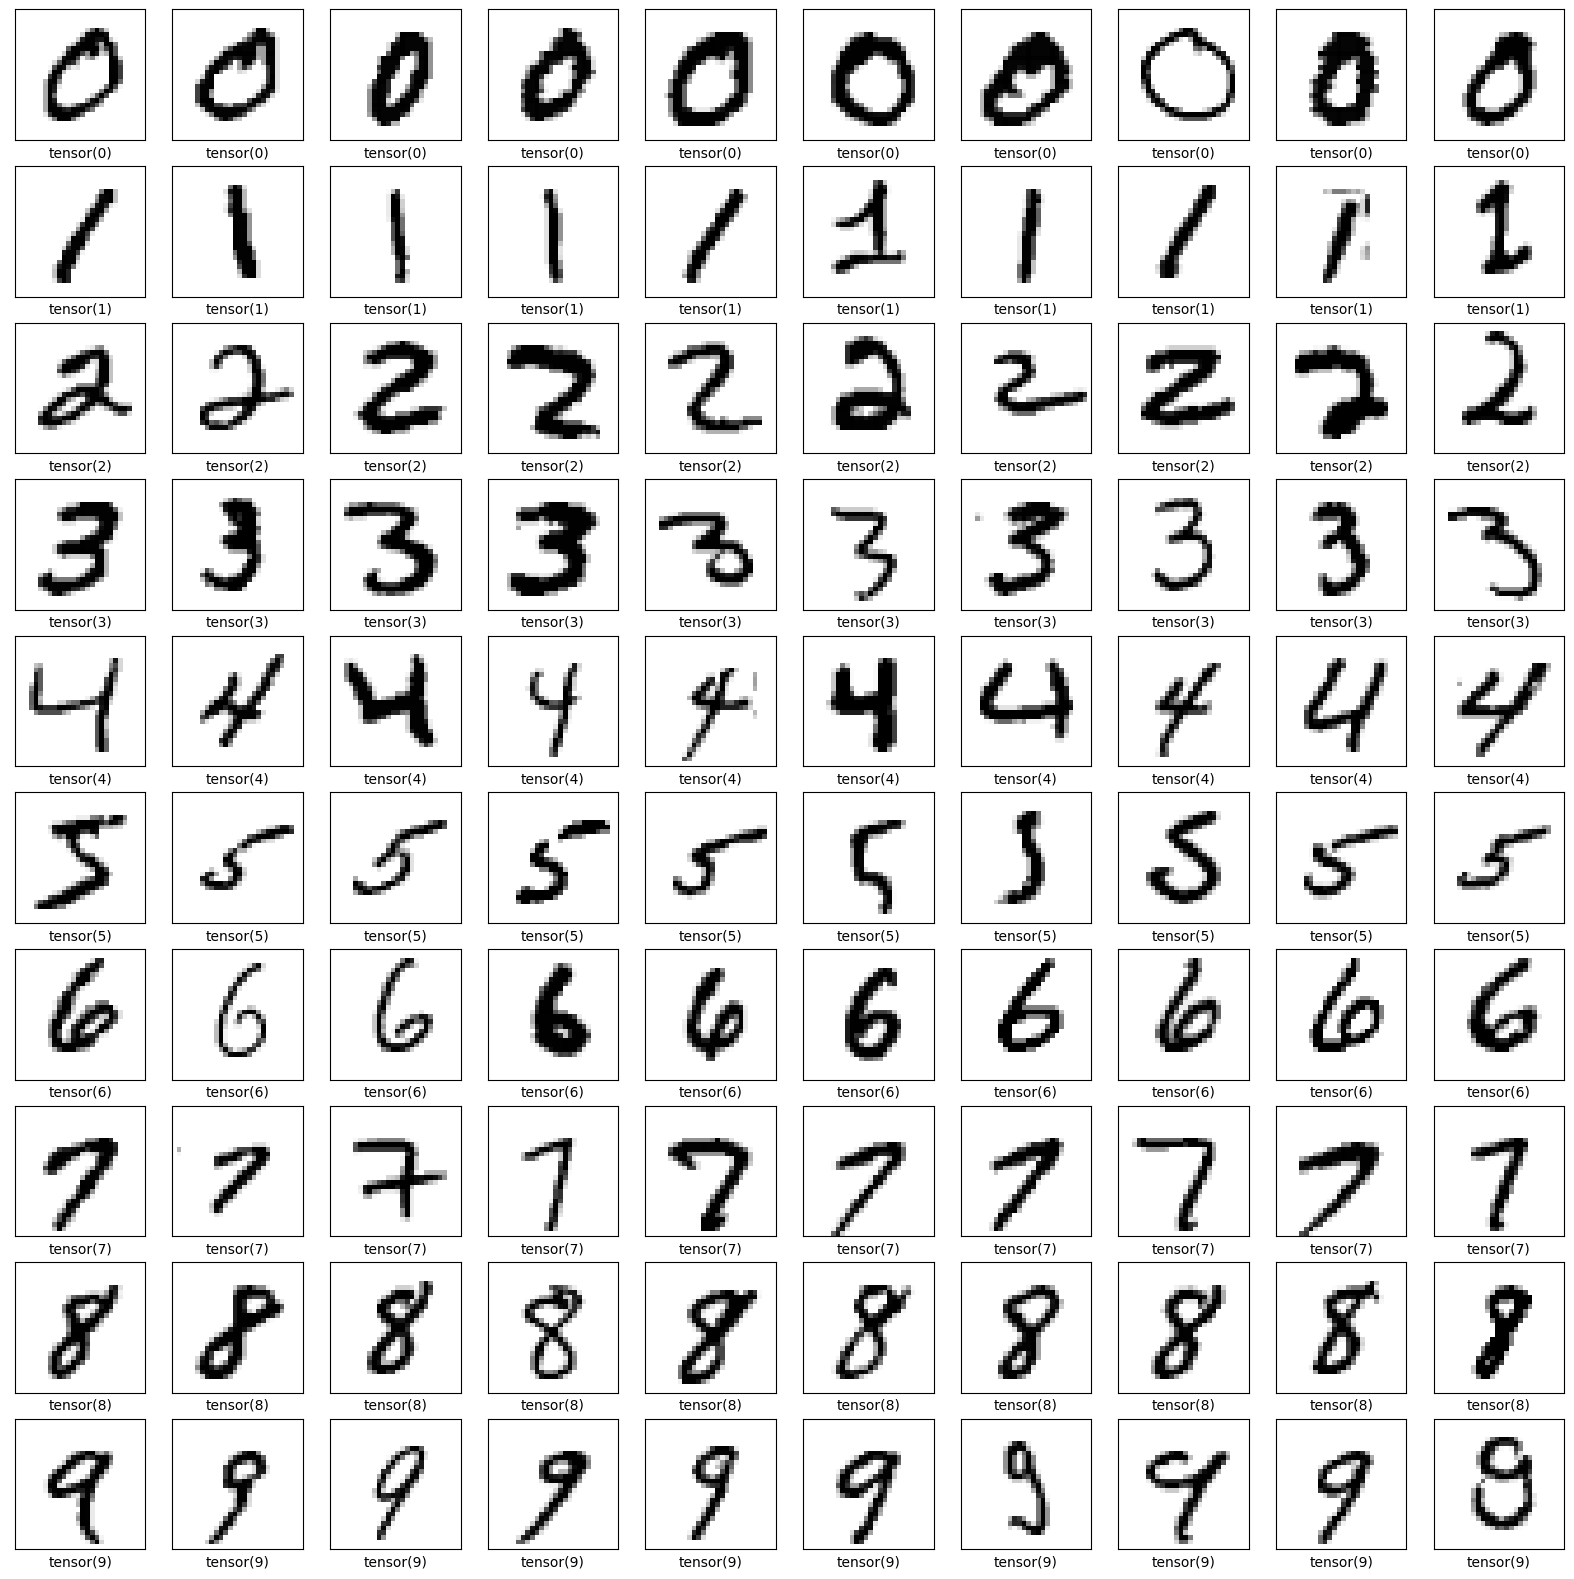

In [ ]:
import matplotlib.pyplot as plt
label_list=np.unique(y_mnist_tr)
print(label_list)
plt.figure(figsize=(20,20))
for j in label_list: 
  cnt=0
  for i in range(6000):
      if(y_mnist_tr[i]==j):
        factor=10*j
        plt.subplot(10,10,cnt+factor+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_mnist_tr[i], cmap=plt.cm.binary)
        plt.xlabel(y_mnist_tr[i])
        cnt=cnt+1
      if(cnt==10):
        break;
plt.show()

**Preprocessing Classes and Functions Common to Various Models.**

**MLP**: Class implements the MLP based on the Pytorch base NN module

**ResNet**: Class implements the ResidualNN based on the Pytorch base NN module

**BasicBlock**: Implements the two-layer 2D convolutions needed for the ResNet


**load_datasets:** loads and outputs training and test data with sizing information regarding inputs and outputs

**Xavier:** Xavier initializes the NN weights based on approach proposed by **Xavier Glorot and Yoshua Bengio** to mitigate the vanish gradient problem. It is used by the MLP. 

**conv3x3:** Applies a 2D convolution over the input planes




In [ ]:
def load_datasets(args):
    d_tr, d_te = torch.load('/content/drive/My Drive/GradientEpisodicMemory-master/data/mnist_permutations.py')
    n_inputs = d_tr[0][1].size(1)
    n_outputs = 0
    for i in range(len(d_tr)):
        n_outputs = max(n_outputs, d_tr[i][2].max().item())
        n_outputs = max(n_outputs, d_te[i][2].max().item())
    return d_tr, d_te, n_inputs, n_outputs + 1, len(d_tr)

def Xavier(m):
    if m.__class__.__name__ == 'Linear':
        fan_in, fan_out = m.weight.data.size(1), m.weight.data.size(0)
        std = 1.0 * math.sqrt(2.0 / (fan_in + fan_out))
        a = math.sqrt(3.0) * std
        m.weight.data.uniform_(-a, a)
        m.bias.data.fill_(0.0)


class MLP(nn.Module):
    def __init__(self, sizes):
        super(MLP, self).__init__()
        layers = []

        for i in range(0, len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < (len(sizes) - 2):
                layers.append(nn.ReLU())

        self.net = nn.Sequential(*layers)
        self.net.apply(Xavier)

    def forward(self, x):
        return self.net(x)


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf

        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(nclasses, nf=20):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)

**Model 1: Single Predictor Trained Across All Tasks** 

Model 1 serves somewhat like a simple control model for use as a basis of comparison. There is no episodic memory meaning that there will be no subset of instances used to minimize the loss per task. It would be expected that this model should display a great deal of catastrophic interference as it is trained for new tasks like classifying permuted images.

The model uses a ResNet18 for the CIFAR-100 data and an MLP for the MNIST data. Stochastic gradient descent is how the NN is trained/optimized. The loss function is the sum of cross entropy loss across all tasks. 

In [ ]:
class SinglePredictorModel(torch.nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_layers,
                 n_hiddens,
                 data_file,
                 lr):
        super(SinglePredictorModel, self).__init__()
        nl, nh = n_layers, n_hiddens
        # setup network
        self.is_cifar = (data_file == 'cifar100.pt')
        if self.is_cifar:
            self.net = ResNet18(n_outputs)
        else:
            self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])

        # setup optimizer
        self.opt = torch.optim.SGD(self.parameters(), lr=lr)

        # setup losses
        self.bce = torch.nn.CrossEntropyLoss()

        if self.is_cifar:
            self.nc_per_task = n_outputs / n_tasks
        else:
            self.nc_per_task = n_outputs
        self.n_outputs = n_outputs

    def compute_offsets(self, task):
        if self.is_cifar:
            offset1 = task * self.nc_per_task
            offset2 = (task + 1) * self.nc_per_task
        else:
            offset1 = 0
            offset2 = self.n_outputs
        return int(offset1), int(offset2)

    def forward(self, x, t):
        output = self.net(x)
        if self.is_cifar:
            # make sure we predict classes within the current task
            offset1, offset2 = self.compute_offsets(t)
            if offset1 > 0:
                output[:, :offset1].data.fill_(-10e10)
            if offset2 < self.n_outputs:
                output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, x, t, y):
        self.train()
        self.zero_grad()
        if self.is_cifar:
            offset1, offset2 = self.compute_offsets(t)
            self.bce((self.net(x)[:, offset1: offset2]),
                     y - offset1).backward()
        else:
            self.bce(self(x, t), y).backward()
        self.opt.step()

**Model 2: Single Independent Predictor per Task**

Model 2 also serves as a useful basis for comparison. An independent predictor is trained with an for each distinct task implying that there will be no catastrophic interference becuase tasks are completely independent. This also implies that the model will less accurate/robust as there is little generalized learning. Nothing learned in task 1 can be applied to task 2 with completely independent predictors. 

The independent predictors have the equivalent architecture (scaled down hidden units given fewer tasks), optimization, and loss function as model 1. Task-level predictor initial weigths will be the best of the weights from the last trained task or random selection. 


In [ ]:
class InpendentPredicatorPerTaskModel(torch.nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_layers,
                 n_hiddens,
                 data_file,
                 lr,
                 fine_tune,
                 cuda):
        super(InpendentPredicatorPerTaskModel, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.nets = torch.nn.ModuleList()
        self.opts = []

        self.is_cifar = (data_file == 'cifar100.pt')
        if self.is_cifar:
            self.nc_per_task = n_outputs / n_tasks
        self.n_outputs = n_outputs

        # setup network
        for _ in range(n_tasks):
            if self.is_cifar:
                self.nets.append(
                    ResNet18(int(n_outputs / n_tasks), int(20 / n_tasks)))
            else:
                self.nets.append(
                    MLP([n_inputs] + [int(nh / n_tasks)] * nl + [n_outputs]))

        # setup optimizer
        for t in range(n_tasks):
            self.opts.append(torch.optim.SGD(self.nets[t].parameters(),
                                             lr=lr))

        # setup loss
        self.bce = torch.nn.CrossEntropyLoss()

        self.finetune = finetune
        self.gpu = cuda
        self.old_task = 0

    def forward(self, x, t):
        output = self.nets[t](x)
        if self.is_cifar:
            bigoutput = torch.Tensor(x.size(0), self.n_outputs)
            if self.gpu:
                bigoutput = bigoutput.cuda()
            bigoutput.fill_(-10e10)
            bigoutput[:, int(t * self.nc_per_task): int((t + 1) * self.nc_per_task)].copy_(
                output.data)
            return bigoutput
        else:
            return output

    def observe(self, x, t, y):
        # detect beginning of a new task
        if self.finetune and t > 0 and t != self.old_task:
            # initialize current network like the previous one
            for ppold, ppnew in zip(self.nets[self.old_task].parameters(),
                                    self.nets[t].parameters()):
                ppnew.data.copy_(ppold.data)
            self.old_task = t

        self.train()
        self.zero_grad()
        if self.is_cifar:
            self.bce(self.nets[t](x), y - int(t * self.nc_per_task)).backward()
        else:
            self.bce(self(x, t), y).backward()
        self.opts[t].step()

**Model 3: Multimodal Predictor**

Multimodal models allow tasks to use input data with different modalities or significantly different feature representations such as audio data for one task and video data for a separate task. This approach can allow for task-specific flexibility while allowing some generalizability of knowledge encoded in the underlying hidden layers. 

This model uses a comparable architecture to Model 1 ("single") model but tasks have distinct input layers. A negative log likelihood loss function is used. 

In [ ]:
def reset_bias(m):
    m.bias.data.fill_(0.0)


class MultimodelPredictorModel(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_hiddens,
                 n_layers,
                 lr):
        super(MultimodelPredictorModel, self).__init__()

        self.i_layer = nn.ModuleList()
        self.h_layer = nn.ModuleList()
        self.o_layer = nn.ModuleList()

        self.n_layers = n_layers
        nh = n_hiddens

        if self.n_layers > 0:
            # dedicated input layer
            for _ in range(n_tasks):
                self.i_layer += [nn.Linear(n_inputs, nh)]
                reset_bias(self.i_layer[-1])

            # shared hidden layer
            self.h_layer += [nn.ModuleList()]
            for _ in range(self.n_layers):
                self.h_layer[0] += [nn.Linear(nh, nh)]
                reset_bias(self.h_layer[0][0])

            # shared output layer
            self.o_layer += [nn.Linear(nh, n_outputs)]
            reset_bias(self.o_layer[-1])

        # linear model falls back to independent models
        else:
            self.i_layer += [nn.Linear(n_inputs, n_outputs)]
            reset_bias(self.i_layer[-1])

        self.relu = nn.ReLU()
        self.soft = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr)

    def forward(self, x, t):
        h = x

        if self.n_layers == 0:
            y = self.soft(self.i_layer[t if isinstance(t, int) else t[0]](h))
        else:
            # task-specific input
            h = self.relu(self.i_layer[t if isinstance(t, int) else t[0]](h))
            # shared hiddens
            for l in range(self.n_layers):
                h = self.relu(self.h_layer[0][l](h))
            # shared output
            y = self.soft(self.o_layer[0](h))

        return y

    def observe(self, x, t, y):
        self.zero_grad()
        self.loss(self.forward(x, t), y).backward()
        self.optimizer.step()

**Model 4: Elastic Weight Consolidation (EWC) Model** 

The EWC model is an approach that seeks to overcome catastrophic interference though regularization to prevent how much neural net weights can change in response to new batches of information. While regularization does reduce catastrophic interference, it does not prevent it entirely. Furthermore the regulaization can to an extent hinder incremental learning leading to lower accuracy than other potential approaches


In [ ]:
class EWCModel(torch.nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_hiddens,
                 n_layers,
                 lr,
                 data_file,
                 memory_strength,
                 n_memories):
        super(EWCModel, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.reg = memory_strength

        # setup network
        self.is_cifar = (data_file == 'cifar100.pt')
        if self.is_cifar:
            self.net = ResNet18(n_outputs)
        else:
            self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])

        # setup optimizer
        self.opt = torch.optim.SGD(self.net.parameters(), lr=lr)

        # setup losses
        self.bce = torch.nn.CrossEntropyLoss()

        # setup memories
        self.current_task = 0
        self.fisher = {}
        self.optpar = {}
        self.memx = None
        self.memy = None

        if self.is_cifar:
            self.nc_per_task = n_outputs / n_tasks
        else:
            self.nc_per_task = n_outputs
        self.n_outputs = n_outputs
        self.n_memories = n_memories

    def compute_offsets(self, task):
        if self.is_cifar:
            offset1 = task * self.nc_per_task
            offset2 = (task + 1) * self.nc_per_task
        else:
            offset1 = 0
            offset2 = self.n_outputs
        return int(offset1), int(offset2)

    def forward(self, x, t):
        output = self.net(x)
        if self.is_cifar:
            # make sure we predict classes within the current task
            offset1, offset2 = self.compute_offsets(t)
            if offset1 > 0:
                output[:, :offset1].data.fill_(-10e10)
            if offset2 < self.n_outputs:
                output[:, int(offset2):self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, x, t, y):
        self.net.train()

        # next task?
        if t != self.current_task:
            self.net.zero_grad()

            if self.is_cifar:
                offset1, offset2 = self.compute_offsets(self.current_task)
                self.bce((self.net(self.memx)[:, offset1: offset2]),
                         self.memy - offset1).backward()
            else:
                self.bce(self(self.memx,
                              self.current_task),
                         self.memy).backward()
            self.fisher[self.current_task] = []
            self.optpar[self.current_task] = []
            for p in self.net.parameters():
                pd = p.data.clone()
                pg = p.grad.data.clone().pow(2)
                self.optpar[self.current_task].append(pd)
                self.fisher[self.current_task].append(pg)
            self.current_task = t
            self.memx = None
            self.memy = None

        if self.memx is None:
            self.memx = x.data.clone()
            self.memy = y.data.clone()
        else:
            if self.memx.size(0) < self.n_memories:
                self.memx = torch.cat((self.memx, x.data.clone()))
                self.memy = torch.cat((self.memy, y.data.clone()))
                if self.memx.size(0) > self.n_memories:
                    self.memx = self.memx[:self.n_memories]
                    self.memy = self.memy[:self.n_memories]

        self.net.zero_grad()
        if self.is_cifar:
            offset1, offset2 = self.compute_offsets(t)
            loss = self.bce((self.net(x)[:, offset1: offset2]),
                            y - offset1)
        else:
            loss = self.bce(self(x, t), y)
        for tt in range(t):
            for i, p in enumerate(self.net.parameters()):
                l = self.reg * self.fisher[tt][i]
                l = l * (p - self.optpar[tt][i]).pow(2)
                loss += l.sum()
        loss.backward()
        self.opt.step()

**Gradient Episodic Memory**

As previously discussed, uses episodic memory where it saves instances for each separate task. When training a new task, optimizing the loss function seeks weights that minimize the current task's loss subject to loss not increasing for the previous episodes/tasks. The previous episode's loss is caluclated using the sample of stored instances. 

Stochastic gradient descent is used for optimization and cross entropy loss is used to calculate loss. 

In [ ]:
# Auxiliary functions useful for GEM's inner optimization.

def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    if is_cifar:
        offset1 = task * nc_per_task
        offset2 = (task + 1) * nc_per_task
    else:
        offset1 = 0
        offset2 = nc_per_task
    return offset1, offset2


def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1


def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.
        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))


class GemModel(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 n_layers,
                 n_hiddens,
                 n_memories,
                 memory_strength,
                 data_file,
                 cuda,
                 lr
                 ):
        super(GemModel, self).__init__()
        nl, nh = n_layers, n_hiddens
        self.margin = memory_strength
        self.is_cifar = (data_file == 'cifar100.pt')
        if self.is_cifar:
            self.net = ResNet18(n_outputs)
        else:
            self.net = MLP([n_inputs] + [nh] * nl + [n_outputs])

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = optim.SGD(self.parameters(), lr)

        self.n_memories = n_memories
        self.gpu = cuda

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if cuda:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        if self.is_cifar:
            self.nc_per_task = int(n_outputs / n_tasks)
        else:
            self.nc_per_task = n_outputs

    def forward(self, x, t):
        output = self.net(x)
        if self.is_cifar:
            # make sure we predict classes within the current task
            offset1 = int(t * self.nc_per_task)
            offset2 = int((t + 1) * self.nc_per_task)
            if offset1 > 0:
                output[:, :offset1].data.fill_(-10e10)
            if offset2 < self.n_outputs:
                output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t

        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        endcnt = min(self.mem_cnt + bsz, self.n_memories)
        effbsz = endcnt - self.mem_cnt
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        if len(self.observed_tasks) > 1:
            for tt in range(len(self.observed_tasks) - 1):
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]

                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                   self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar)
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1:
            # copy gradient
            store_grad(self.parameters, self.grads, self.grad_dims, t)
            indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                else torch.LongTensor(self.observed_tasks[:-1])
            dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                            self.grads.index_select(1, indx))
            if (dotp < 0).sum() != 0:
                project2cone2(self.grads[:, t].unsqueeze(1),
                              self.grads.index_select(1, indx), self.margin)
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                               self.grad_dims)
        self.opt.step()

**Testing Infrastucture**

We now set up our testing infrastructure. The Continuum class creates permuted data to use as a new task and test the extent of catastrophic forgetting. The eval_tasks and life_experience functions output the result of the different models using the permuted data. 

In [ ]:
class Continuum:

    def __init__(self, data,batch_size,shuffle_tasks, samples_per_task,n_epochs):
        self.data = data
        self.batch_size = batch_size
        n_tasks = len(data)
        task_permutation = range(n_tasks)

        if shuffle_tasks == 'yes':
            task_permutation = torch.randperm(n_tasks).tolist()

        sample_permutations = []

        for t in range(n_tasks):
            N = data[t][1].size(0)
            if samples_per_task <= 0:
                n = N
            else:
                n = min(samples_per_task, N)

            p = torch.randperm(N)[0:n]
            sample_permutations.append(p)

        self.permutation = []

        for t in range(n_tasks):
            task_t = task_permutation[t]
            for _ in range(n_epochs):
                task_p = [[task_t, i] for i in sample_permutations[task_t]]
                random.shuffle(task_p)
                self.permutation += task_p

        self.length = len(self.permutation)
        self.current = 0

    def __iter__(self):
        return self

    def next(self):
        return self.__next__()

    def __next__(self):
        if self.current >= self.length:
            raise StopIteration
        else:
            ti = self.permutation[self.current][0]
            j = []
            i = 0
            while (((self.current + i) < self.length) and
                   (self.permutation[self.current + i][0] == ti) and
                   (i < self.batch_size)):
                j.append(self.permutation[self.current + i][1])
                i += 1
            self.current += i
            j = torch.LongTensor(j)
            return self.data[ti][1][j], ti, self.data[ti][2][j]

In [ ]:
def eval_tasks(model, tasks, cuda):
    model.eval()
    result = []
    for i, task in enumerate(tasks):
        t = i
        x = task[1]
        y = task[2]
        rt = 0
        
        eval_bs = x.size(0)

        for b_from in range(0, x.size(0), eval_bs):
            b_to = min(b_from + eval_bs, x.size(0) - 1)
            if b_from == b_to:
                xb = x[b_from].view(1, -1)
                yb = torch.LongTensor([y[b_to]]).view(1, -1)
            else:
                xb = x[b_from:b_to]
                yb = y[b_from:b_to]
            # if cuda:
            #     xb = xb.cuda()
            _, pb = torch.max(model(xb, t).data.cpu(), 1, keepdim=False)
            rt += (pb == yb).float().sum()

        result.append(rt / x.size(0))

    return result

In [ ]:
def life_experience(model, continuum, x_te, log_every,cuda):
    result_a = []
    result_t = []

    current_task = 0
    time_start = time.time()

    for (i, (x, t, y)) in enumerate(continuum):
        if(((i % log_every) == 0) or (t != current_task)):
            result_a.append(eval_tasks(model, x_te, cuda))
            result_t.append(current_task)
            current_task = t

        v_x = x.view(x.size(0), -1)
        v_y = y.long()

        # if cuda:
        #     v_x = v_x.cuda()
        #     v_y = v_y.cuda()

        model.train()
        model.observe(v_x, t, v_y)

    result_a.append(eval_tasks(model, x_te, cuda))
    result_t.append(current_task)

    time_end = time.time()
    time_spent = time_end - time_start
    return torch.Tensor(result_t), torch.Tensor(result_a), time_spent

In [ ]:
def task_changes(result_t):
    n_tasks = int(result_t.max() + 1)
    changes = []
    current = result_t[0]
    for i, t in enumerate(result_t):
        if t != current:
            changes.append(i)
            current = t

    return n_tasks, changes
def confusion_matrix(result_t, result_a, fname=None):
    nt, changes = task_changes(result_t)

    baseline = result_a[0]
    changes = torch.LongTensor(changes + [result_a.size(0)]) - 1
    result = result_a[changes]

    # acc[t] equals result[t,t]
    acc = result.diag()
    fin = result[nt - 1]
    # bwt[t] equals result[T,t] - acc[t]
    bwt = result[nt - 1] - acc

    # fwt[t] equals result[t-1,t] - baseline[t]
    fwt = torch.zeros(nt)
    for t in range(1, nt):
        fwt[t] = result[t - 1, t] - baseline[t]

    if fname is None:
        #f = open(fname, 'w')

        print(' '.join(['%.4f' % r for r in baseline]))
        #print('|', file=f)
        for row in range(result.size(0)):
            print(' '.join(['%.4f' % r for r in result[row]]))
        print('')
        print('Diagonal Accuracy: %.4f' % acc.mean())
        print('Final Accuracy: %.4f' % fin.mean())
        print('Backward: %.4f' % bwt.mean())
        print('Forward:  %.4f' % fwt.mean())
        #f.close()

    stats = []
    stats.append(acc.mean())
    stats.append(fin.mean())
    stats.append(bwt.mean())
    stats.append(fwt.mean())

    return stats

In [ ]:
import importlib
import datetime
import argparse
import random
import uuid
import time
import os
import torch
import numpy as np

n_hiddens=100 #number of hidden neurons at each layer
n_layers=2 #number of hidden layers
lr=1e-3 #SGD learning rate
batch_size=10 #batch_size
shuffle_tasks='no'#present tasks in order
samples_per_task=-1 #training samples per task (all if negative)
n_epochs=10#Number of epochs per task
log_every=100#frequency of logs, in minibatches
cuda='no' #'Use GPU?'
seed=0#'random seed'
n_tasks=3#number of tasks
model='ewc'
data_file=""
memory_strength=0 #(meaning depends on memory)
n_memories=0#number of memories per task
if model == 'multimodal':
    n_layers -= 1


# initialize seeds
torch.backends.cudnn.enabled = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed) 

# load data 

tasks_tr = []
tasks_te = []
x_tr = x_mnist_tr
x_te = x_mnist_te
y_tr = y_mnist_tr
y_te = y_mnist_te
x_tr = x_tr.float().view(x_tr.size(0), -1) / 255.0
x_te = x_te.float().view(x_te.size(0), -1) / 255.0
y_tr = y_tr.view(-1).long()
y_te = y_te.view(-1).long()

for t in range(n_tasks):
    p = torch.randperm(x_tr.size(1)).long().view(-1)
    tasks_tr.append(['random permutation', x_tr.index_select(1, p), y_tr])
    tasks_te.append(['random permutation', x_te.index_select(1, p), y_te])

#load_data()
d_tr = tasks_tr
d_te =tasks_te  
n_inputs = d_tr[0][1].size(1)
n_outputs = 0
for i in range(len(d_tr)):
   n_outputs = max(n_outputs, d_tr[i][2].max().item())
   n_outputs = max(n_outputs, d_te[i][2].max().item())
x_tr=d_tr
x_te=d_te
n_outputs = n_outputs +1
n_tasks= len(d_tr)

**We now run ours tests**

**1.Single Model**

In [ ]:
# single model exececution.
# set up continuum

continuum = Continuum(x_tr,batch_size,shuffle_tasks, samples_per_task,n_epochs)
print("Model 1 : Single Model Output")
model = SinglePredictorModel(n_inputs, n_outputs, n_tasks, n_layers, n_hiddens, data_file, lr)
result_t, result_a, spent_time = life_experience(model, continuum, x_te,log_every,cuda)
stats_single = confusion_matrix(result_t, result_a)
print(stats_single)


Model 1 : Single Model Output
0.0750 0.1075 0.0780
0.9386 0.0833 0.1057
0.8993 0.9468 0.0816
0.7196 0.8911 0.9533

Diagonal Accuracy: 0.9462
Final Accuracy: 0.8547
Backward: -0.0916
Forward:  -0.0069
[tensor(0.9462), tensor(0.8547), tensor(-0.0916), tensor(-0.0069)]


# **2.Independent Predicator**

In [ ]:
# Inpendent Predicator Per Task Model exececution.
# set up continuum
continuum = Continuum(x_tr,batch_size,shuffle_tasks, samples_per_task,n_epochs)
print("Model 2 : Inpendent Predicator Per Task Model")
finetune='yes'
cuda='yes'
model = InpendentPredicatorPerTaskModel(n_inputs, n_outputs, n_tasks, n_layers, n_hiddens, data_file, lr, finetune, cuda)
result_t, result_a, spent_time = life_experience(model, continuum, x_te,log_every,cuda)
stats_independent = confusion_matrix(result_t, result_a)
print(stats_independent)


Model 2 : Inpendent Predicator Per Task Model
0.0878 0.0858 0.0930
0.9313 0.0858 0.0930
0.9313 0.9394 0.0930
0.9313 0.9394 0.9448

Diagonal Accuracy: 0.9385
Final Accuracy: 0.9385
Backward: 0.0000
Forward:  0.0000
[tensor(0.9385), tensor(0.9385), tensor(0.), tensor(0.)]


**3.MultiModal**

In [ ]:
# Multi-Model
# set up continuum
continuum = Continuum(x_tr,batch_size,shuffle_tasks, samples_per_task,n_epochs)
print("Model 3 : Multimodel model execution")
model = MultimodelPredictorModel(n_inputs, n_outputs, n_tasks,n_hiddens,n_layers,lr)
result_t, result_a, spent_time = life_experience(model, continuum, x_te,log_every,cuda)
stats_multimodel = confusion_matrix(result_t, result_a)
print(stats_multimodel)


Model 3 : Multimodel model execution
0.0531 0.1388 0.1297
0.9220 0.1199 0.1126
0.9135 0.9549 0.1181
0.9047 0.9506 0.9628

Diagonal Accuracy: 0.9466
Final Accuracy: 0.9394
Backward: -0.0072
Forward:  -0.0102
[tensor(0.9466), tensor(0.9394), tensor(-0.0072), tensor(-0.0102)]


**4.EWC MODEL**

In [ ]:
# EWC-Model
# set up continuum
continuum = Continuum(x_tr,batch_size,shuffle_tasks, samples_per_task,n_epochs)
print("Model 4 : EWC Model execution")
model = EWCModel(n_inputs, n_outputs, n_tasks,n_hiddens,n_layers,lr,data_file,memory_strength,n_memories)
result_t, result_a, spent_time = life_experience(model, continuum, x_te,log_every,cuda)
stats_ewcModel = confusion_matrix(result_t, result_a)
print(stats_ewcModel)


Model 4 : EWC Model execution
0.0909 0.0893 0.0888
0.9387 0.1035 0.0711
0.8904 0.9490 0.0673
0.7875 0.9149 0.9520

Diagonal Accuracy: 0.9466
Final Accuracy: 0.8848
Backward: -0.0618
Forward:  -0.0024
[tensor(0.9466), tensor(0.8848), tensor(-0.0618), tensor(-0.0024)]


**5.GEM MODEL**

In [ ]:
# GEM-Model
# set up continuum
continuum = Continuum(x_tr,batch_size,shuffle_tasks, samples_per_task,n_epochs)
print("Model 5 : GEM-Model execution")
model = GemModel(n_inputs, n_outputs, n_tasks, n_layers, n_hiddens, n_memories, memory_strength, data_file, None, lr)
result_t, result_a, spent_time = life_experience(model, continuum, x_te,log_every,cuda)
stats_gemModel = confusion_matrix(result_t, result_a)
print(stats_gemModel)


Model 6 : GEM-Model execution
0.1056 0.0845 0.0635
0.9386 0.1314 0.0933
0.8842 0.9470 0.0813
0.7336 0.9248 0.9536

Diagonal Accuracy: 0.9464
Final Accuracy: 0.8707
Backward: -0.0757
Forward:  0.0216
[tensor(0.9464), tensor(0.8707), tensor(-0.0757), tensor(0.0216)]


**Let us now visually compare the results obtained from various models we discussed above**

In [ ]:
import numpy as np
print(stats_single)
accuracies=np.zeros(6)
BWT=np.zeros(6)
FWT=np.zeros(6)

accuracies[0]=stats_single[1]
BWT[0]=stats_single[2]
FWT[0]=stats_single[3]

accuracies[1]=stats_independent[1]
BWT[1]=stats_independent[2]
FWT[1]=stats_independent[3]

accuracies[2]=stats_multimodel[1]
BWT[2]=stats_multimodel[2]
FWT[2]=stats_multimodel[3]

accuracies[3]=stats_ewcModel[1]
BWT[3]=stats_ewcModel[2]
FWT[3]=stats_ewcModel[3]

accuracies[4]=stats_gemModel[1]
BWT[4]=stats_gemModel[2]
FWT[4]=stats_gemModel[3]
print(accuracies)
print(BWT)
print(FWT)

[tensor(0.9462), tensor(0.8547), tensor(-0.0916), tensor(-0.0069)]
[0.85466671 0.93849999 0.93936664 0.88479996 0.87066668 0.        ]
[-0.09156666  0.         -0.0072     -0.06176667 -0.07573334  0.        ]
[-0.00686667  0.         -0.01016666 -0.00243333  0.02156667  0.        ]


Accuracy plot of various models for 10 epochs


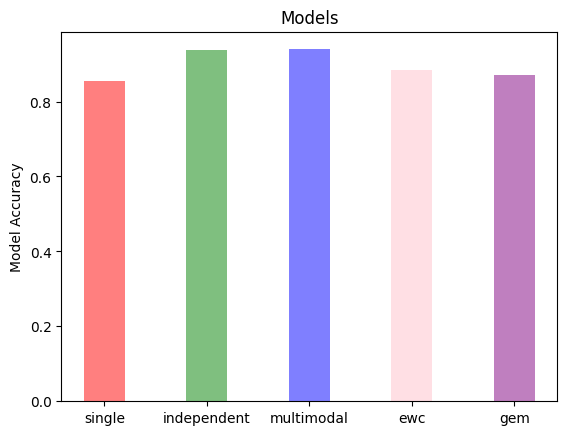

Backward Transfer plot of various models for 10 epochs


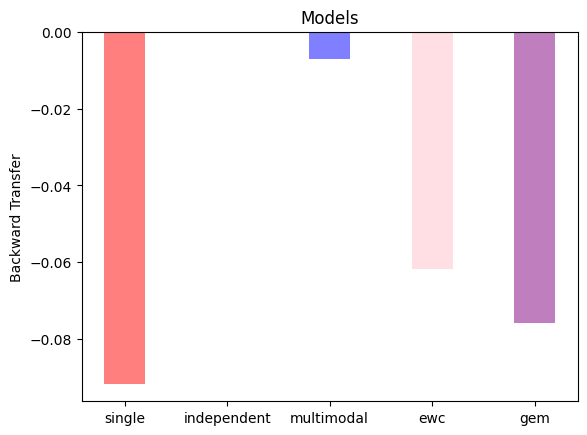

Forward Transfer plot of various models for 10 epochs


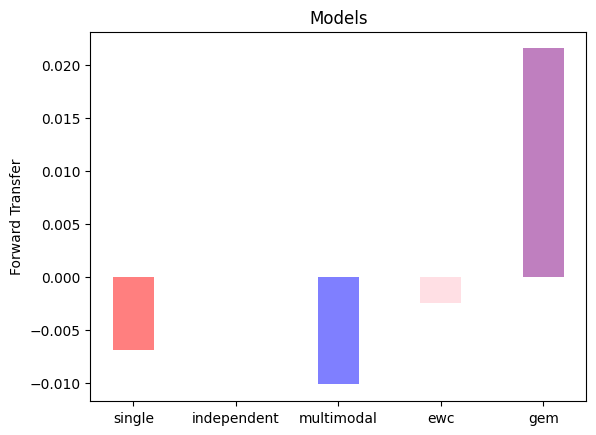

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
modellist = ('single', 'independent', 'multimodal', 'ewc', 'gem')
x= np.arange(len(modellist))
colors = {'single': 'red',
          'independent': 'green',
          'multimodal': 'blue',
          'icarl': 'yellow',
          'ewc': 'pink',
          'gem': 'purple'}
print("Accuracy plot of various models for 10 epochs")
all_colors = []
for xi, yi, li in zip(x, accuracies, modellist):
  plt.bar(xi, yi,color=colors[li],align='center', alpha=0.5,width=0.4)
  all_colors.append(colors[li])
plt.xticks(x, modellist)
plt.ylabel('Model Accuracy')
plt.title('Models')
plt.show()
print("Backward Transfer plot of various models for 10 epochs")
for xi, yi, li in zip(x, BWT, modellist):
  plt.bar(xi, yi,color=colors[li],align='center', alpha=0.5,width=0.4)
plt.xticks(x, modellist)
plt.ylabel('Backward Transfer')
plt.title('Models')
plt.show()
print("Forward Transfer plot of various models for 10 epochs")
for xi, yi, li in zip(x, FWT, modellist):
  plt.bar(xi, yi,color=colors[li],align='center', alpha=0.5,width=0.4)
plt.xticks(x, modellist)
plt.ylabel('Forward Transfer')
plt.title('Models')
plt.show()

**Conclusion**

Below are the recorded accuracies for different models:

1. Model 1 : Single

    Diagonal Accuracy: 94.62%
    
    Final Accuracy: 85.47%
    
    Backward: -9.16%
    
    Forward:  -0.69%


2. Model 2 : Independent

    Diagonal Accuracy: 93.85%

    Final Accuracy: 93.85%

    Backward: 0

    Forward:  0


3. Model 3 : Multimodal

    Diagonal Accuracy: 94.66%

    Final Accuracy: 93.94%

    Backward: -0.72%

    Forward:  -1.02%


4. Model 4 : EWC

    Diagonal Accuracy: 94.66%
    
    Final Accuracy: 88.48%
    
    Backward: -6.18%
    
    Forward:  -0.24%


5. GEM Model

    Diagonal Accuracy: 94.64%
    
    Final Accuracy: 87.07%
    
    Backward: -7.57%
    
    Forward:  2.16%

We were a bit surprised to note that GEM did not perform as well as initially expected. We expected results consistent with the Paz-Ranzato paper where GEM would have high accuracy and minimal negative backwards transfer or catastrophic interference. Intead given the parameters we used, GEM par-level accuracy and high negative backwards interference. We suspect that GEM would perform better with an increasing number of epochs.

Other results however, were consistent with out expectations. The single, "control" model displayed high levels of catastrophic interference. The "independent" model displayed not catastrophic interference as expected given that every task has a separate model effectively. The EWC, regularization model, displayed less catastrophic interference than the "control" single model, but still displayed a relatively high level of forgetting. The multimodal model performed well as expected with a model that is rather flexible.  


**References-**
We have referred the following papers and links

1)Lopez-Ranzato paper- http://papers.nips.cc/paper/7225-gradient-episodic-memory-for-continual-learning.pdf) 

2)https://arxiv.org/pdf/1612.00796.pdf

3)https://openreview.net/attachment?id=H1g79ySYvB&name=original_pdf

4)http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?source=post_page

5)github-https://github.com/facebookresearch/GradientEpisodicMemory 


